# Note: This File is Kaggle compatable, need to upload Data and weights before running a model.

In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers

In [2]:
training_path = '/kaggle/input/car-dmage-data-v4/data3a/training'
testing_path = '/kaggle/input/car-dmage-data-v4/data3a/validation'

In [3]:
batch_size = 32
img_height = 224
img_width = 224

In [4]:
train_data_gen = ImageDataGenerator(rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        validation_split=0.20,) 

train_ds = train_data_gen.flow_from_directory(
    training_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  
    subset='training', 
    seed=123,
    shuffle=True  
)
valid_ds = train_data_gen.flow_from_directory(
    training_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  
    subset='validation', 
    seed=123,
    shuffle=True  
)

Found 1108 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


In [5]:
test_data_gen = ImageDataGenerator(rescale=1./255,)

test_ds = test_data_gen.flow_from_directory(
    testing_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 248 images belonging to 3 classes.


# Note: In Kaggle if we are using a pretrained model we also need weights file and path must be set but in Colab the weights are downloaded automatically and weights must be equal to imagenet in the code.

# Existing Models

# ResNet50

In [18]:
base_model = ResNet50(weights='/kaggle/input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))


for layer in base_model.layers:
    layer.trainable = True
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 7

In [19]:
epochs=50

history_resnet = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    verbose=1,
)
all_train_histories = [history_resnet.history['accuracy']]
all_val_histories = [history_resnet.history['val_accuracy']]


Epoch 1/50
35/35 [==============================] - 25s 557ms/step - loss: 1.2176 - accuracy: 0.4278 - val_loss: 1.3051 - val_accuracy: 0.3273
Epoch 2/50
35/35 [==============================] - 17s 489ms/step - loss: 0.9140 - accuracy: 0.5830 - val_loss: 1.5932 - val_accuracy: 0.3273
Epoch 3/50
35/35 [==============================] - 17s 478ms/step - loss: 0.8084 - accuracy: 0.6200 - val_loss: 1.1401 - val_accuracy: 0.3273
Epoch 4/50
35/35 [==============================] - 17s 491ms/step - loss: 0.6666 - accuracy: 0.7103 - val_loss: 1.4348 - val_accuracy: 0.3745
Epoch 5/50
35/35 [==============================] - 17s 486ms/step - loss: 0.5622 - accuracy: 0.7491 - val_loss: 1.7838 - val_accuracy: 0.3273
Epoch 6/50
35/35 [==============================] - 17s 493ms/step - loss: 0.4726 - accuracy: 0.8042 - val_loss: 1.3312 - val_accuracy: 0.3127
Epoch 7/50
35/35 [==============================] - 17s 486ms/step - loss: 0.4015 - accuracy: 0.8421 - val_loss: 5.7704 - val_accuracy: 0.3273

In [20]:
model.save('model_rs50.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


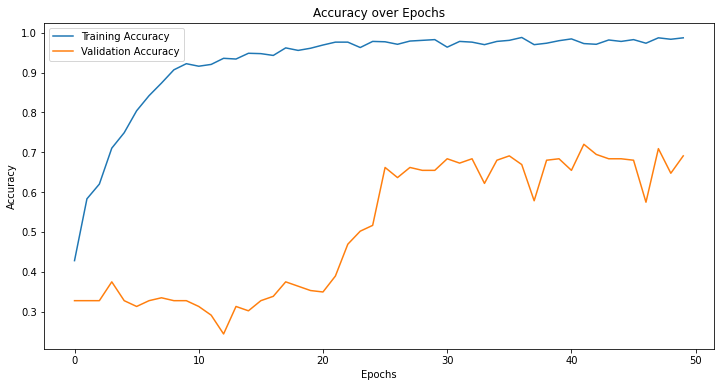

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

In [27]:
from sklearn.metrics import classification_report
true_labels = test_ds.classes
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.79      0.71      0.75        82
           1       0.46      0.59      0.52        75
           2       0.79      0.69      0.74        91

    accuracy                           0.67       248
   macro avg       0.68      0.66      0.67       248
weighted avg       0.69      0.67      0.67       248



# VGG19

In [30]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

img_size = (224, 224) 
class_count = 3 

base_model = VGG19(weights='/kaggle/input/vgg19-weights/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(img_size[0], img_size[1], 3))

x = base_model.output
x = Flatten()(x) 
x = Dense(256, activation='relu')(x)  
output = Dense(class_count, activation='softmax')(x)  
model_vgg = Model(inputs=base_model.input, outputs=output)

model_vgg.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [31]:
epochs=50

history_vgg = model_vgg.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    verbose=1,
)
all_train_histories = [history_vgg.history['accuracy']]
all_val_histories = [history_vgg.history['val_accuracy']]

Epoch 1/50
35/35 [==============================] - 28s 652ms/step - loss: 8.1883 - accuracy: 0.3366 - val_loss: 1.0987 - val_accuracy: 0.3345
Epoch 2/50
35/35 [==============================] - 17s 477ms/step - loss: 1.1127 - accuracy: 0.3394 - val_loss: 1.1019 - val_accuracy: 0.3382
Epoch 3/50
35/35 [==============================] - 16s 467ms/step - loss: 1.1273 - accuracy: 0.3213 - val_loss: 1.0989 - val_accuracy: 0.3345
Epoch 4/50
35/35 [==============================] - 17s 487ms/step - loss: 1.1073 - accuracy: 0.3159 - val_loss: 1.0984 - val_accuracy: 0.3418
Epoch 5/50
35/35 [==============================] - 20s 580ms/step - loss: 1.0994 - accuracy: 0.3213 - val_loss: 1.0986 - val_accuracy: 0.3345
Epoch 6/50
35/35 [==============================] - 17s 488ms/step - loss: 1.0988 - accuracy: 0.3348 - val_loss: 1.0986 - val_accuracy: 0.3345
Epoch 7/50
35/35 [==============================] - 17s 494ms/step - loss: 1.0986 - accuracy: 0.3348 - val_loss: 1.0986 - val_accuracy: 0.3345

In [32]:
model_vgg.save('model_vgg19.h5')

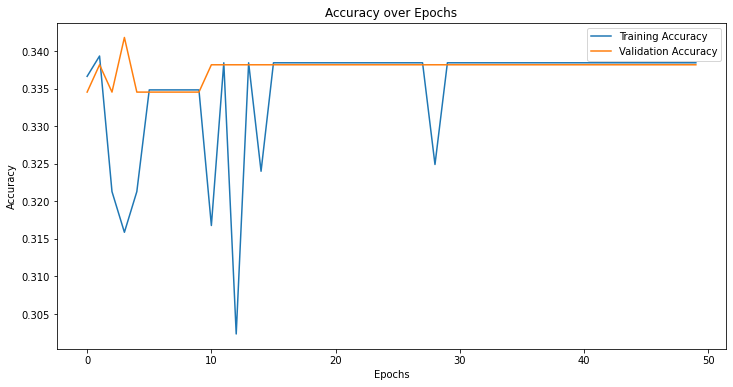

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

In [36]:
from sklearn.metrics import classification_report
true_labels = test_ds.classes
predictions = model_vgg.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.00      0.00      0.00        75
           2       0.37      1.00      0.54        91

    accuracy                           0.37       248
   macro avg       0.12      0.33      0.18       248
weighted avg       0.13      0.37      0.20       248



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Primary Proposed Model(version1)

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def resnet_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, shortcut])
    return layers.Activation('relu')(x)

inputs = layers.Input(shape=(224, 224, 3))

base_model = tf.keras.applications.DenseNet169(include_top=False, weights='/kaggle/input/densenet/densenet169_weights_tf_dim_ordering_tf_kernels_notop (1).h5', input_tensor=inputs)
x = base_model(inputs)

x = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(x)

for _ in range(2):  
    x = resnet_block(x, 256)

x = layers.GlobalMaxPooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256,
                 activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
x = layers.Dropout(rate=0.4)(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet169 (Functional)        (None, 7, 7, 1664)   12642880    input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_454 (Conv2D)             (None, 7, 7, 256)    426240      densenet169[0][0]                
__________________________________________________________________________________________________
conv2d_455 (Conv2D)             (None, 7, 7, 256)    590080      conv2d_454[0][0]                 
____________________________________________________________________________________________

In [29]:
epochs=50
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,  
    verbose=1,
)
all_train_histories = [history.history['accuracy']]
all_val_histories = [history.history['val_accuracy']]

Epoch 1/50
35/35 [==============================] - 17s 476ms/step - loss: 0.3385 - accuracy: 0.9513 - val_loss: 1.8098 - val_accuracy: 0.6000
Epoch 2/50
35/35 [==============================] - 17s 468ms/step - loss: 0.3337 - accuracy: 0.9666 - val_loss: 1.6945 - val_accuracy: 0.6473
Epoch 3/50
35/35 [==============================] - 16s 466ms/step - loss: 0.3162 - accuracy: 0.9693 - val_loss: 1.2944 - val_accuracy: 0.6509
Epoch 4/50
35/35 [==============================] - 17s 479ms/step - loss: 0.3277 - accuracy: 0.9603 - val_loss: 1.7021 - val_accuracy: 0.5673
Epoch 5/50
35/35 [==============================] - 16s 467ms/step - loss: 0.3104 - accuracy: 0.9648 - val_loss: 1.7111 - val_accuracy: 0.6145
Epoch 6/50
35/35 [==============================] - 16s 465ms/step - loss: 0.3175 - accuracy: 0.9603 - val_loss: 1.5990 - val_accuracy: 0.5927
Epoch 7/50
35/35 [==============================] - 16s 466ms/step - loss: 0.3052 - accuracy: 0.9711 - val_loss: 1.7556 - val_accuracy: 0.5636

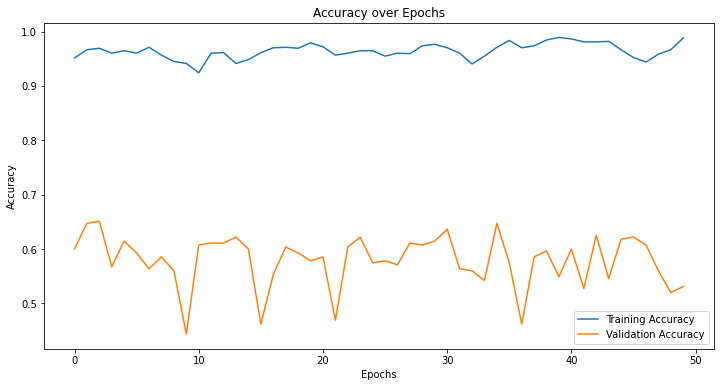

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

In [31]:
from sklearn.metrics import classification_report
true_labels = test_ds.classes
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.51      0.83      0.63        82
           1       0.45      0.47      0.46        75
           2       0.78      0.32      0.45        91

    accuracy                           0.53       248
   macro avg       0.58      0.54      0.51       248
weighted avg       0.59      0.53      0.51       248



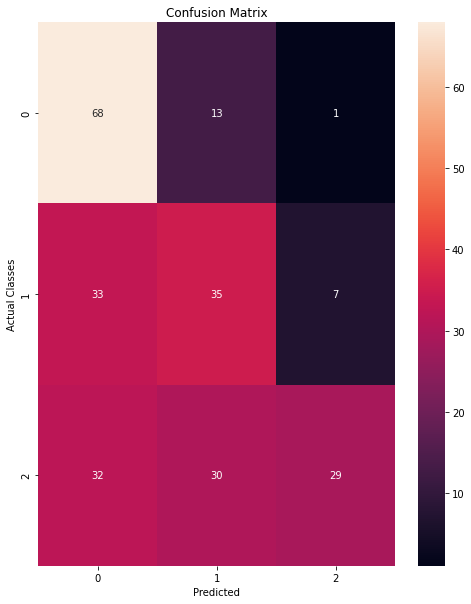

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
true_labels = test_ds.classes
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)


plt.figure(figsize=(8, 10))
sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

# Main Resnet and Densenet Hybrid Model (final_version)

# #DentNet 

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

inputs = layers.Input(shape=(224, 224, 3))

# Load ResNet50 with predefined weights
resnet_base = tf.keras.applications.ResNet50(
    include_top=False,
    weights='/kaggle/input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
    input_tensor=inputs
)
x_resnet = resnet_base(inputs)
x_resnet = layers.GlobalAveragePooling2D()(x_resnet)


densenet_base = tf.keras.applications.DenseNet169(
    include_top=False,
    weights='/kaggle/input/densenet/densenet169_weights_tf_dim_ordering_tf_kernels_notop (1).h5',
    input_shape=(224, 224, 3)
)
x_densenet = densenet_base(inputs)
x_densenet = layers.GlobalAveragePooling2D()(x_densenet)

x = layers.Concatenate()([x_resnet, x_densenet])

x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
x = layers.Dropout(rate=0.4)(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 7, 7, 2048)   23587712    input_1[0][0]                    
__________________________________________________________________________________________________
densenet169 (Functional)        (None, 7, 7, 1664)   12642880    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           resnet50[0][0]                   
______________________________________________________________________________________________

In [7]:
epochs=50
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,  
    verbose=1,
)
all_train_histories = [history.history['accuracy']]
all_val_histories = [history.history['val_accuracy']]

Epoch 1/50
35/35 [==============================] - 77s 1s/step - loss: 95.6861 - accuracy: 0.4865 - val_loss: 939876.5625 - val_accuracy: 0.3273
Epoch 2/50
35/35 [==============================] - 30s 836ms/step - loss: 13.2096 - accuracy: 0.5532 - val_loss: 2941.0225 - val_accuracy: 0.3345
Epoch 3/50
35/35 [==============================] - 30s 854ms/step - loss: 4.3175 - accuracy: 0.5496 - val_loss: 8.9322 - val_accuracy: 0.3382
Epoch 4/50
35/35 [==============================] - 30s 852ms/step - loss: 3.5262 - accuracy: 0.5632 - val_loss: 25933.6621 - val_accuracy: 0.3273
Epoch 5/50
35/35 [==============================] - 30s 855ms/step - loss: 3.3838 - accuracy: 0.5722 - val_loss: 3.9272 - val_accuracy: 0.3891
Epoch 6/50
35/35 [==============================] - 30s 849ms/step - loss: 3.4323 - accuracy: 0.6029 - val_loss: 3.5383 - val_accuracy: 0.3709
Epoch 7/50
35/35 [==============================] - 30s 855ms/step - loss: 3.0804 - accuracy: 0.6282 - val_loss: 3.4028 - val_accur

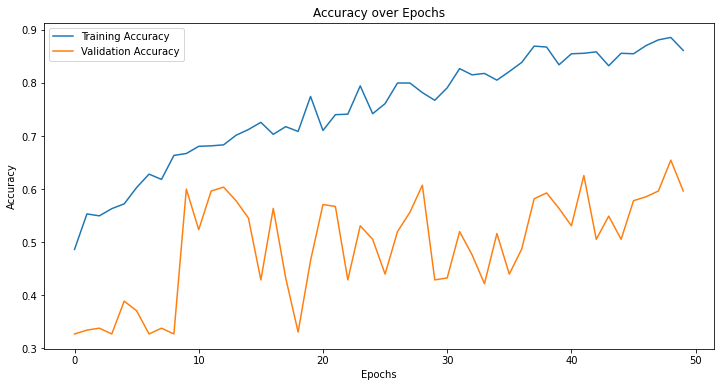

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

In [9]:
from sklearn.metrics import classification_report
true_labels = test_ds.classes
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.57      0.66      0.61        82
           1       0.42      0.36      0.39        75
           2       0.71      0.69      0.70        91

    accuracy                           0.58       248
   macro avg       0.57      0.57      0.57       248
weighted avg       0.58      0.58      0.58       248



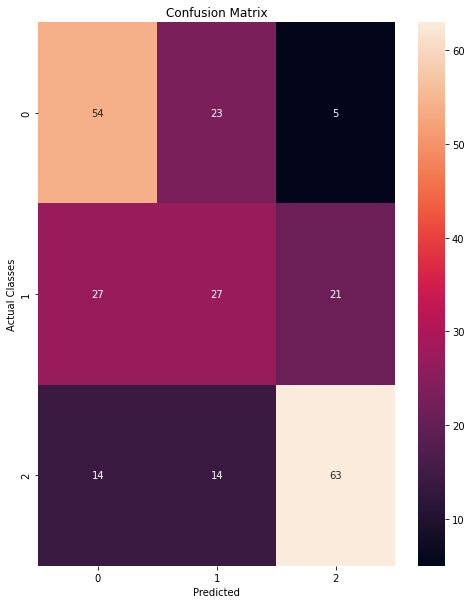

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
true_labels = test_ds.classes
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)


plt.figure(figsize=(8, 10))
sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

# Cost Estimation Function

Predicted Severity: Less Damage, Estimated Price: ₹4731.61


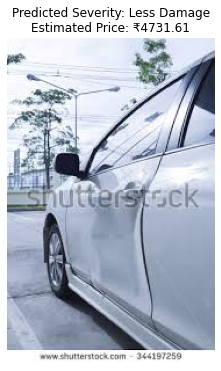

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

price_ranges = {
    "Less Damage": (4000, 8000),
    "Moderate Damage": (8000, 15000),
    "Severe Damage": (15000, 35000)
}

def create_damage_price_dataset(num_samples):
    data = []
    
    for _ in range(num_samples):
        severity = np.random.choice(list(price_ranges.keys()))
        min_price, max_price = price_ranges[severity]
        price = np.random.uniform(min_price, max_price)
        
        data.append({
            "Damage Severity": severity,
            "Price": round(price, 2)
        })

    df = pd.DataFrame(data)
    return df

num_samples = 1000
damage_price_dataset = create_damage_price_dataset(num_samples)

label_encoder = LabelEncoder()
damage_price_dataset['Damage Severity Encoded'] = label_encoder.fit_transform(damage_price_dataset['Damage Severity'])

X = damage_price_dataset[['Damage Severity Encoded']]
y = damage_price_dataset['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_damage_severity(model, img_path):
    severities = ["Less Damage", "Moderate Damage", "Severe Damage"]
    predicted_severity = np.random.choice(severities)
    
    return predicted_severity

def predict_price_for_image(model, img_path):
    predicted_severity = predict_damage_severity(model, img_path)
    
    encoded_severity = label_encoder.transform([predicted_severity])[0]
    
    X_new = pd.DataFrame({'Damage Severity Encoded': [encoded_severity]})
    predicted_price = model.predict(X_new)[0]
    
    return predicted_severity, round(predicted_price, 2)

image_path = "/kaggle/input/car-dmage-data-v4/data3a/validation/01-minor/0011.jpeg"

predicted_severity, predicted_price = predict_price_for_image(model, image_path)

print(f"Predicted Severity: {predicted_severity}, Estimated Price: ₹{predicted_price:.2f}")

def display_image_with_prediction(img_path):
    img = image.load_img(img_path)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Predicted Severity: {predicted_severity}\nEstimated Price: ₹{predicted_price:.2f}")
    plt.axis('off')
    plt.show()

display_image_with_prediction(image_path)